In [1]:
import pywt
import matplotlib.pyplot as plt
from numpy.fft import fft
import numpy as np
import librosa
SAMPLE_RATE = 24000

In [ ]:
"""
saw, _ = librosa.load("C:\\Users\\abdulg\\source\\repos\\Synth\\backwards\\waves\\saw.wav", sr=SAMPLE_RATE)
sine, _ = librosa.load("C:\\Users\\abdulg\\source\\repos\\Synth\\backwards\\waves\\sine.wav", sr=SAMPLE_RATE)
square, _ = librosa.load("C:\\Users\\abdulg\\source\\repos\\Synth\\backwards\\waves\\square.wav", sr=SAMPLE_RATE)
up, _ = librosa.load("C:\\Users\\abdulg\\source\\repos\\Synth\\backwards\\waves\\filterUp.wav", sr=SAMPLE_RATE)
down, _ = librosa.load("C:\\Users\\abdulg\\source\\repos\\Synth\\backwards\\waves\\filterDown.wav", sr=SAMPLE_RATE)
flute, _ = librosa.load("C:\\Users\\abdulg\\source\\repos\\Synth\\backwards\\waves\\basic flute.wav", sr=SAMPLE_RATE)
"""

signal, _ = librosa.load("C:\\Users\\abdulg\\source\\repos\\Synth\\backwards\\validationdata\\53.wav", sr = SAMPLE_RATE)

In [ ]:
def plotWaveform(ax, signal, sr, numpoints):
    librosa.display.waveshow(signal, sr=sr, ax=ax, max_points=numpoints)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude")

def plotSpectrogram(ax, signal, sr):
	ax.specgram(signal, sr, cmap="viridis")

def plotScaleogram(ax, signal, waveletname="cmor"):
	scales = np.arange(1, 200)  
	coeffs, _ = pywt.cwt(signal, scales, waveletname)
	ax.imshow(np.abs(coeffs), extent=[0, len(signal), 1, 200], cmap="viridis", aspect="auto", origin="lower")
	ax.xlabel("Sample")
	ax.ylabel("Scale")

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3)

signals = [sine, saw, square]
for i in range(0,3):
	plotWaveform(axes[0, i], signals[i], SAMPLE_RATE, int(3 * SAMPLE_RATE / 261))
	plotSpectrogram(axes[1,i], signals[i], SAMPLE_RATE)
	plotScaleogram(axes[2,i], signals[i])

fig.show()

#Plotting code

In [ ]:
#todo replace spectrogram images with this
stft = librosa.stft(down)
db = librosa.amplitude_to_db(np.abs(stft), ref=np.max)
plt.figure()
librosa.display.specshow(S_db)

In [ ]:
plt.specgram(flute, SAMPLE_RATE, cmap="viridis", Fs=SAMPLE_RATE)
plt.axis(ymax = 1000)
plt.axis("off")
plt.show()

In [ ]:
#show a scaleogram
signal, _ = librosa.load("C:\\Users\\abdulg\\source\\repos\\Synth\\backwards\\validationdata\\123.wav", sr = SAMPLE_RATE)
scales = np.arange(1, 30)  
coeffs, _ = pywt.cwt(signal, scales, "mexh")
plt.imshow(np.abs(coeffs), extent=[0, len(signal), 1, 30], cmap="viridis", aspect="auto", origin="lower")
plt.axis("off")
plt.show()

In [ ]:
#fft plotting code
signal = flute
spectrum = np.fft.fft(signal)
frequencies = np.fft.fftfreq(len(signal), d=1/16000)

# Plot only positive frequencies and their magnitudes
plt.plot(frequencies[:len(frequencies)//10], np.abs(spectrum)[:len(frequencies)//10])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')

plt.show()

In [ ]:
#too big!
np.shape(coeffs)

In [ ]:
#try downsampling, but we introduce 'ripples' in the image that could confuse the CNN for an LFO
coeffs2 = block_reduce(coeffs, (2,32), np.max)
print(np.shape(coeffs2))
plt.imshow(np.abs(coeffs2), extent=[0, len(signal), 1, 80], cmap="viridis", aspect="auto", origin="lower")
plt.axis("off")
plt.show()

In [ ]:
import pickle
with open("./lastHistory", "rb") as histFile:
	history = pickle.load(histFile)
	plt.plot(history["loss"])
	plt.plot(history["val_loss"])
	plt.title("model loss")
	plt.ylabel("loss")
	plt.xlabel("epoch")
	plt.legend(["train", "val"], loc="upper left")
	plt.show()

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dct
import glob
import os

EXAMPLES_PER_BATCH = 32
WAVELET_NAME = "mexh"
WAVELET_SCALES = np.arange(1, 30)  
SAMPLE_RATE = 16000
SAMPLES_PER_EXAMPLE = 64000
NUM_WAVES = 3
NUM_OTHER_FEATURES = 11
NUM_DCT_COEFFICIENTS = 1400
SYNTHESIZER_PATH = "C:\\Users\\abdulg\\source\\repos\\Synth\\out\\build\\x64-debug\\synth.exe"

PARAMETER_LBS = np.asarray([0, 0, 0, 440, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
PARAMETER_RANGE = np.asarray([1, 1, 1, 1661.22, 1661, 1, 1, 1, 1, 1, 8, 1/2, 8, 1/32]) - PARAMETER_LBS

def normaliseParams(params):
	return (params - PARAMETER_LBS)/PARAMETER_RANGE

def processWavs(datapath):
	waveFiles = sorted(glob.glob(os.path.join(datapath, "*.wav")))
	waves = [librosa.load(waveFile, sr=SAMPLE_RATE, dtype=np.float32)[0] for waveFile in waveFiles]
	scaleograms = [pywt.cwt(wave, WAVELET_SCALES, WAVELET_NAME)[0] for wave in waves]

	return (
		np.asarray([dct(scaleo, type=2, axis=1)[:, :NUM_DCT_COEFFICIENTS] for scaleo in scaleograms])
	)

def getValidationSet():
	print("generating validation data")
	datapath = os.path.abspath("./validationdata")
	#subprocess.run(f"{SYNTHESIZER_PATH} 600 {datapath}", stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
	return processWavs(datapath)

#energy
arrs = getValidationSet()
indices = np.arange((arrs[0].shape)[-1])

for arr in arrs:
    plt.bar(indices, np.sum(np.square(arr), axis=0), alpha=0.1) 

plt.xlabel("Index")
plt.ylabel("Value")

plt.show()

generating validation data


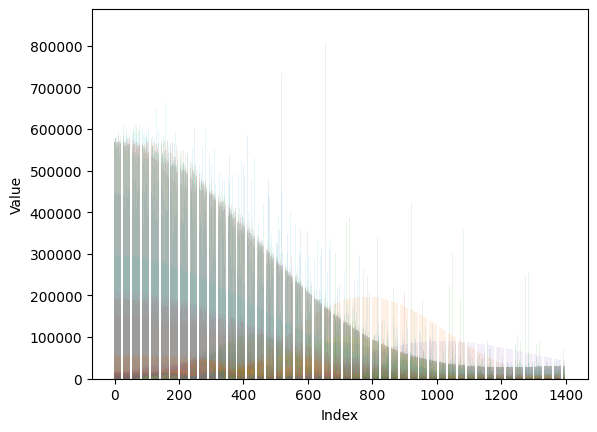